# Analysis of environmental data
In this notebook, we will analyze the oceanographic data collected during the Spring Campaign of 2023. The data was collected using a CTD (Conductivity, Temperature, Depth) sensor and the ships underway system. The CTD sensor was deployed every hour at 4 different locations in the Southern North Sea. We'll start with importing the data into this notebook for analysis.

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

In [35]:
ctd_data = pd.read_csv('../data/raw/environmental_data.csv', sep=';', index_col=0)
# Make sure the index is a DateTimeIndex type to manipulate dates efficiently
ctd_data.index = pd.to_datetime(ctd_data.index)

# Only include data from stations 51 and 130
ctd_data = ctd_data[ctd_data['StationPrefix'].isin(['51', '130'])]

# It looks like the time is off by two hours (it is in UST), so we'll add two hours to the index
ctd_data.index = ctd_data.index + pd.Timedelta(hours=2)

In [36]:
ctd_data['Day'].unique()

array([18, 19, 20, 21])

Now, let's add time of high and low tides. We downloaded tidal predictions from the [Flanders Maritime Agency](https://www.agentschapmdk.be/nl/publicaties#getijgegevens-2023), and used the tables for Vlissingen (Station 51) and Ostend (Station 130). In Vlissingen we sampled from 18/04/2023 13:00 to 19/04/2023 09:00. In Ostend we sampled from 20/4/2023 10:00 to 21/4/2023 10:00. Here's the values:

| Location | Date | high tide | low tide | station |
| :-------: | :--------: | :---: | :----------: | :---: |
| Vlissingen | 18/04/2023 | 13:52 | 20:12 | 51 |
| Vlissingen | 19/04/2023 | 02:06 | 08:40 | 51 |
| Ostend | 20/04/2023 | 01:45 | 08:33 | 130 |
| Ostend | 20/04/2023 | 14:12 | 20:50 | 130 |
| Ostend | 21/04/2023 | 02:26 | 09:14 | 130 |

In [37]:
# Create a tides dataframe
tides_df = pd.DataFrame({
    'Location': ['Vlissingen', 'Vlissingen', 'Ostend', 'Ostend'],
    'Datetime_high_tide': pd.to_datetime(['18/04/2023 13:52', '19/04/2023 02:06', 
                                          '20/04/2023 14:12', '21/04/2023 02:26']),
    'Datetime_low_tide': pd.to_datetime(['18/04/2023 20:12', '19/04/2023 08:40', 
                                         '20/04/2023 20:50', '21/04/2023 09:14']),
    'Station': [51, 51, 130, 130]
})

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_46941/2416954571.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  'Datetime_high_tide': pd.to_datetime(['18/04/2023 13:52', '19/04/2023 02:06',
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_46941/2416954571.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  'Datetime_low_tide': pd.to_datetime(['18/04/2023 20:12', '19/04/2023 08:40',


In [34]:
def plot_environmental_variable(ctd_data, tides_df, variable, y_limits, output_dir):
    """
    Plot the specified environmental variable over time, colored per station.
    It will also add vertical lines for high and low tides, and shade the period between them.

    Parameters:
    ctd_data (DataFrame): The CTD data containing the environmental variables.
    tides_df (DataFrame): The tides data containing high and low tide times.
    variable (str): The name of the environmental variable to plot.
    y_limits (tuple): The y-axis limits for the plot.
    output_dir (str): The directory where the plot files will be saved.
    """

    # Initiate the plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # Creating the lineplot
    sns.lineplot(x=ctd_data.index, y=variable,
                 hue="StationPrefix",
                 style="StationPrefix",
                 markers=True,
                 dashes=False,
                 data=ctd_data, ax=ax)

    # Setting the title with the parameter being plotted
    ax.set_title(f'{variable} Over Time')

    # Set y axis limits
    ax.set_ylim(y_limits)

    # Formatting the x-axis to show day and month
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

    # Showing time every 4 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    # Rotating and showing the x-axis labels
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    # Showing a grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add vertical lines and shaded regions for high and low tides
    for index, row in tides_df.iterrows():
        if str(row['Station']) in ctd_data['StationPrefix'].unique():
            if ctd_data.index.min() <= row['Datetime_high_tide'] <= ctd_data.index.max():
                ax.axvline(row['Datetime_high_tide'], color='#FB5656', linestyle='-', linewidth=1)
                high_tide_time = row['Datetime_high_tide']
            if ctd_data.index.min() <= row['Datetime_low_tide'] <= ctd_data.index.max():
                ax.axvline(row['Datetime_low_tide'], color='#89BCD6', linestyle='-', linewidth=1)
                low_tide_time = row['Datetime_low_tide']
                # Add grey background for the period between high and low tides
                if 'high_tide_time' in locals() and high_tide_time < low_tide_time:
                    ax.axvspan(high_tide_time, low_tide_time, color='lightgrey', alpha=0.3)
                    del high_tide_time

    # Saving the plot as a .svg and .png file
    plt.savefig(f'{output_dir}/{variable}.svg', format='svg')
    plt.savefig(f'{output_dir}/{variable}.png', format='png')
    # Display the plot
    plt.show()

def plot_environmental_variable_per_station(ctd_data, tides_df, variable, y_limits, output_dir):
    """
    Plot the specified environmental variable over time, per station.
    It will also add vertical lines for high and low tides, and shade the period between them.

    Parameters:
    ctd_data (DataFrame): The CTD data containing the environmental variables.
    tides_df (DataFrame): The tides data containing high and low tide times.
    variable (str): The name of the environmental variable to plot.
    y_limits (tuple): The y-axis limits for the plot.
    output_dir (str): The directory where the plot files will be saved.
    """
    
    # List of unique station prefixes
    stations = ctd_data['Station'].str.split('_').str[0].unique()

    # Loop over each station to create individual plots
    for station in stations:
        station_data = ctd_data[ctd_data['Station'].str.startswith(station)]
        station_tides = tides_df[tides_df['Station'] == int(station)]
        
        # Plot the average environmental variable over time for the current station
        fig, ax = plt.subplots(figsize=(5, 4))

        # Creating the lineplot
        sns.lineplot(x=station_data.index, y=variable,
                     hue="StationPrefix",
                     style="StationPrefix",
                     markers=True,
                     dashes=False,
                     data=station_data, ax=ax)

        # Setting the title with the parameter being plotted
        ax.set_title(f'{variable} Over Time - Station {station}')

        # Set y axis limits
        ax.set_ylim(y_limits)

        # Formatting the x-axis to show day and month
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

        # Showing time every 4 hours
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

        # Rotating and showing the x-axis labels
        ax.tick_params(axis='x', rotation=45)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

        # Showing a grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Add vertical lines and shaded regions for high and low tides
        for index, row in station_tides.iterrows():
            if station_data.index.min() <= row['Datetime_high_tide'] <= station_data.index.max():
                ax.axvline(row['Datetime_high_tide'], color='#FB5656', linestyle='-', linewidth=1)
                high_tide_time = row['Datetime_high_tide']
            if station_data.index.min() <= row['Datetime_low_tide'] <= station_data.index.max():
                ax.axvline(row['Datetime_low_tide'], color='#89BCD6', linestyle='-', linewidth=1)
                low_tide_time = row['Datetime_low_tide']
                # Add grey background for the period between high and low tides
                if 'high_tide_time' in locals() and high_tide_time < low_tide_time:
                    ax.axvspan(high_tide_time, low_tide_time, color='lightgrey', alpha=0.3)
                    del high_tide_time

        # Saving the plot as .svg and .png files with station prefix and variable name in the filename
        plt.savefig(f'{output_dir}/{variable}_{station}.svg', format='svg')
        plt.savefig(f'{output_dir}/{variable}_{station}.png', format='png')
        # Display the plot
        plt.show()

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


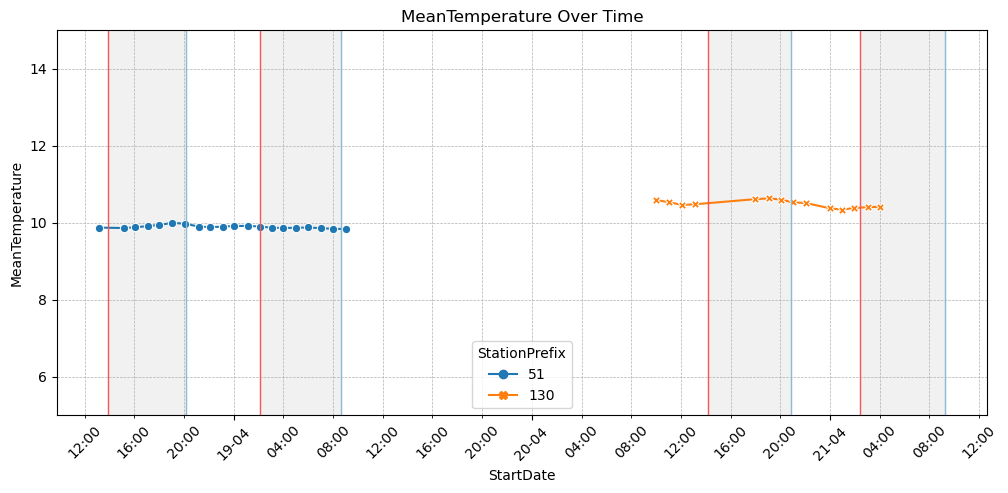

In [35]:
plot_environmental_variable(ctd_data, tides_df, 'MeanTemperature', (5, 15), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


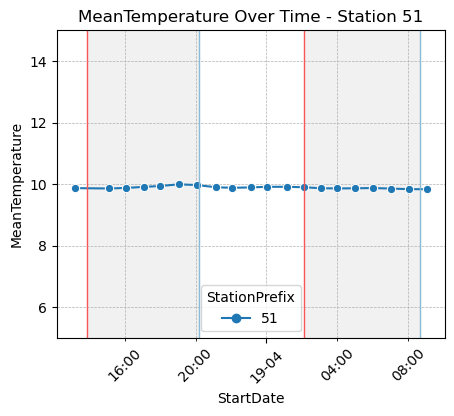

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


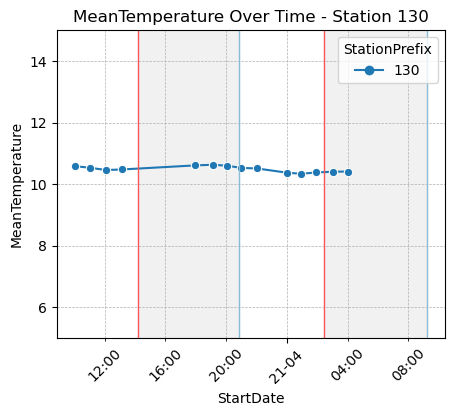

In [36]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTemperature', (5, 15), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


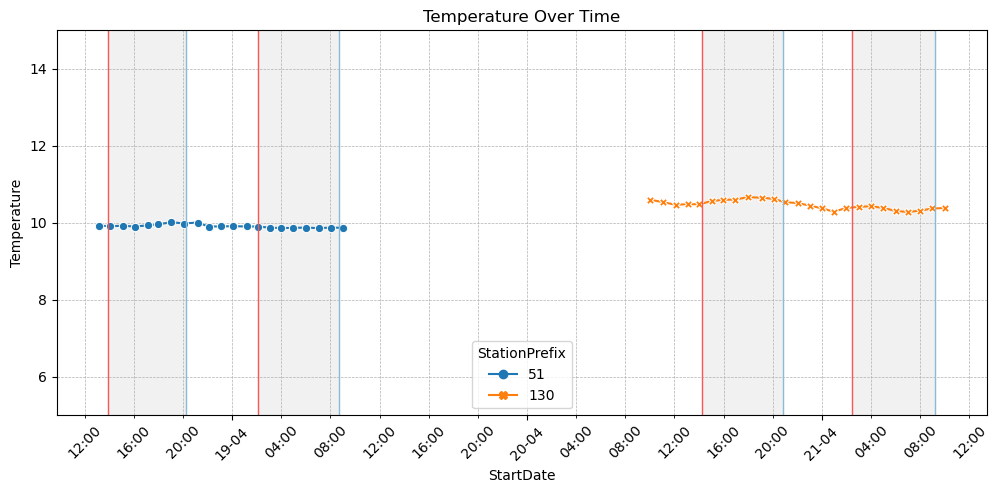

In [38]:
plot_environmental_variable(ctd_data, tides_df, 'Temperature', (5, 15), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


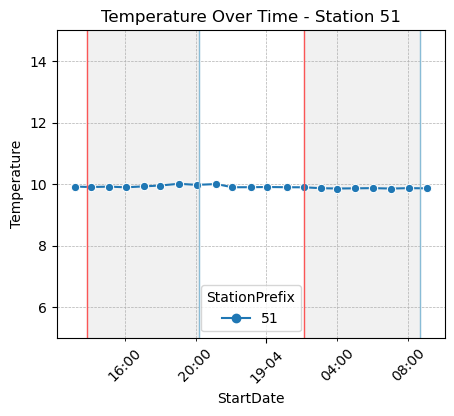

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


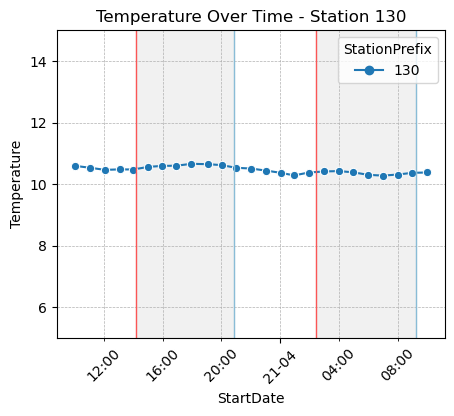

In [39]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Temperature', (5, 15), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


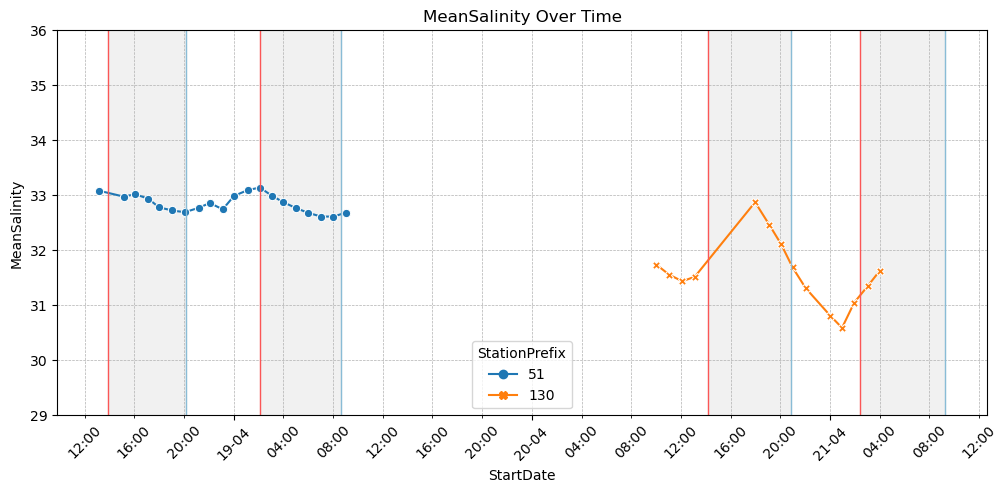

In [40]:
plot_environmental_variable(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


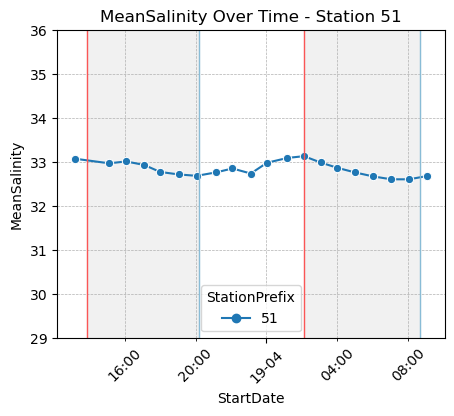

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


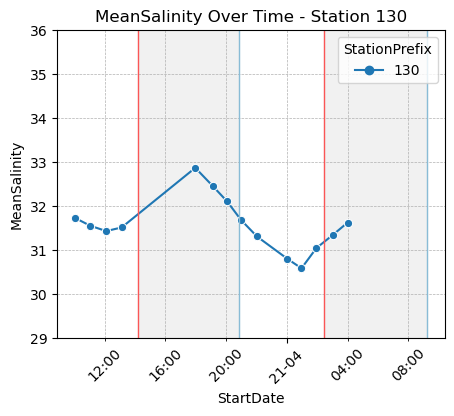

In [41]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


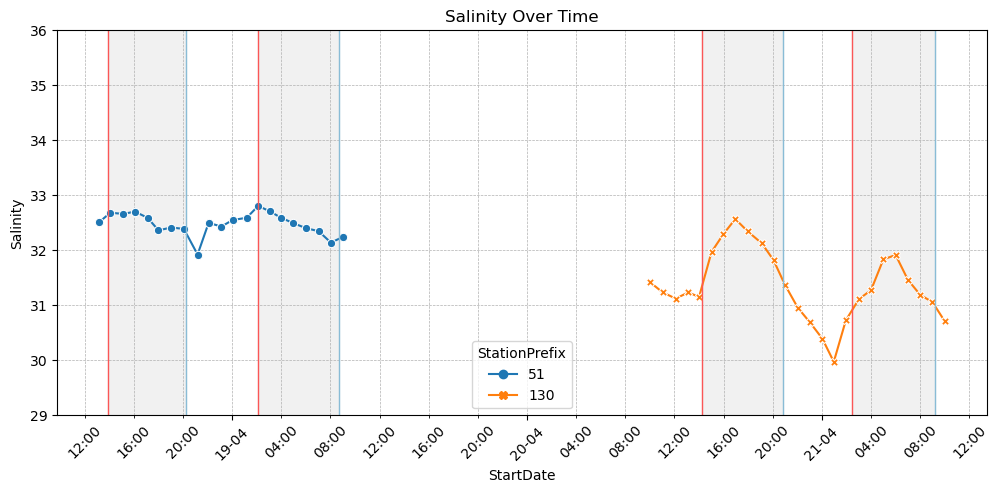

In [42]:
plot_environmental_variable(ctd_data, tides_df, 'Salinity', (29, 36), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


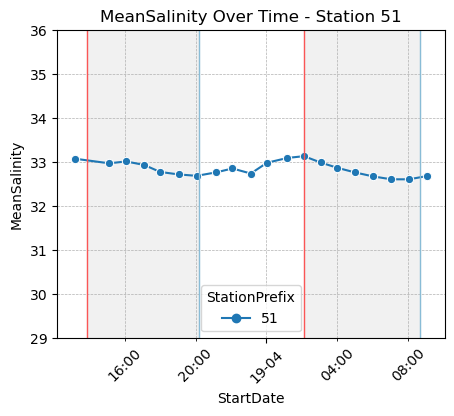

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


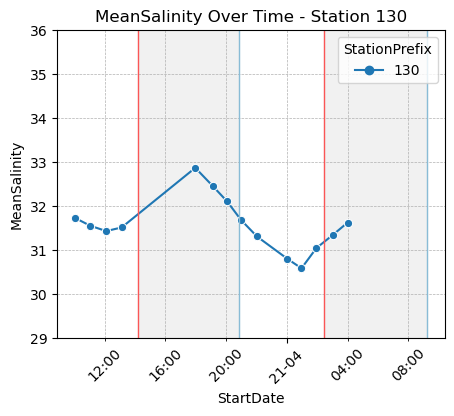

In [43]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


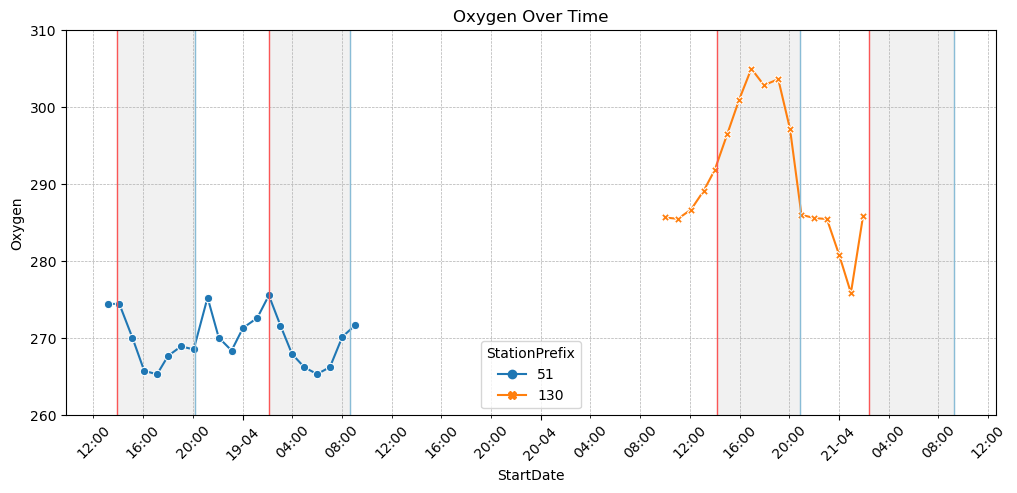

In [45]:
plot_environmental_variable(ctd_data, tides_df, 'Oxygen', (260, 310), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


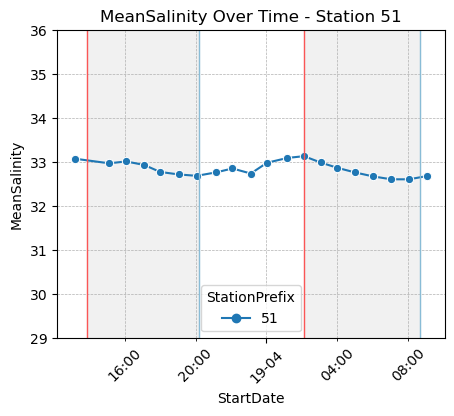

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


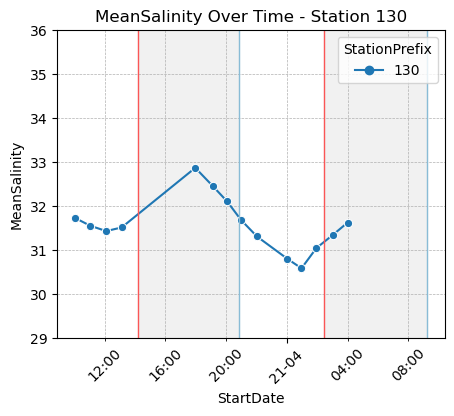

In [46]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


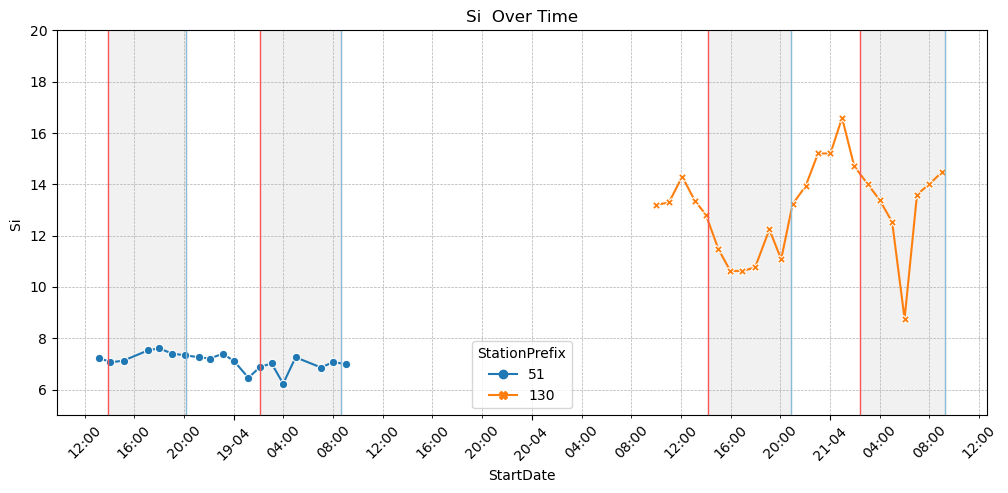

In [49]:
plot_environmental_variable(ctd_data, tides_df, 'Si ', (5, 20), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


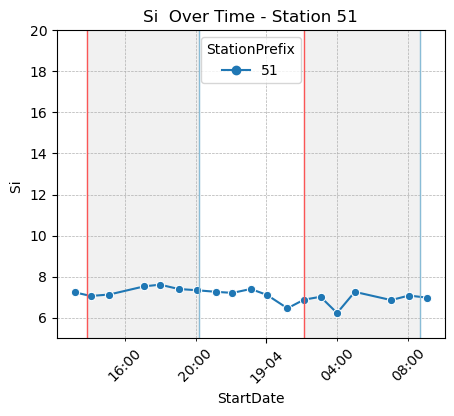

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


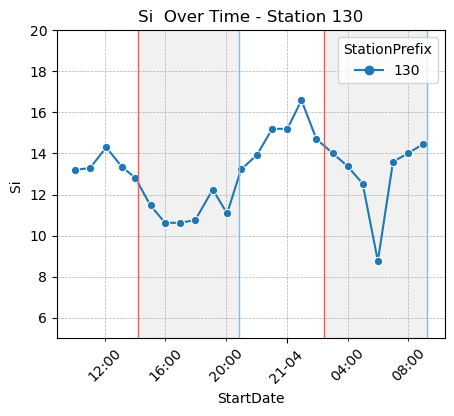

In [50]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Si ', (5, 20), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


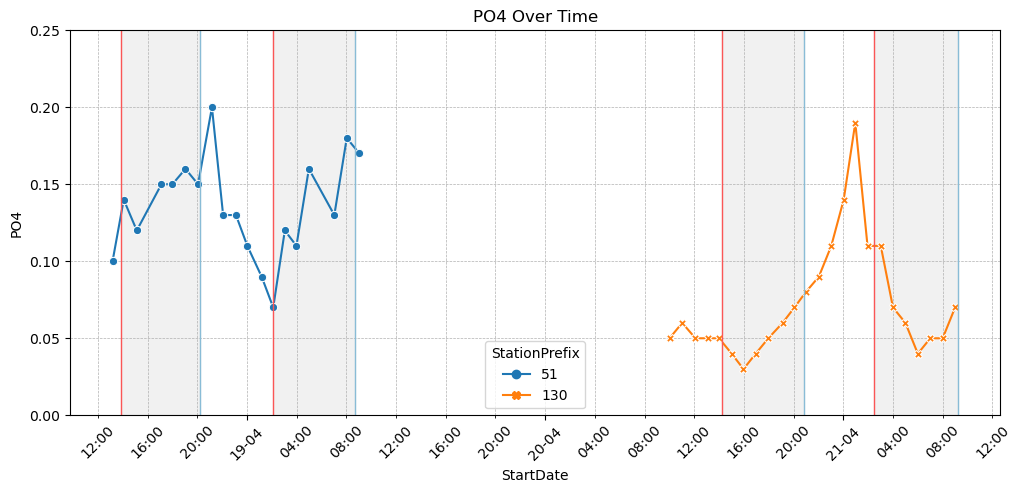

In [51]:
plot_environmental_variable(ctd_data, tides_df, 'PO4', (0, 0.25), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


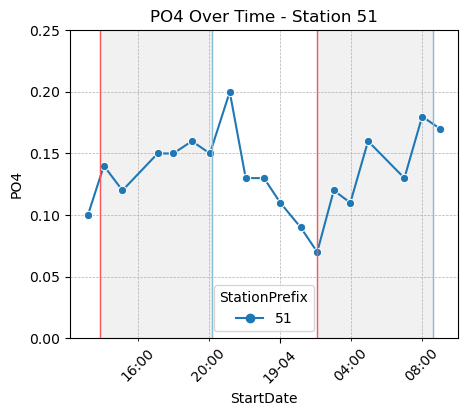

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


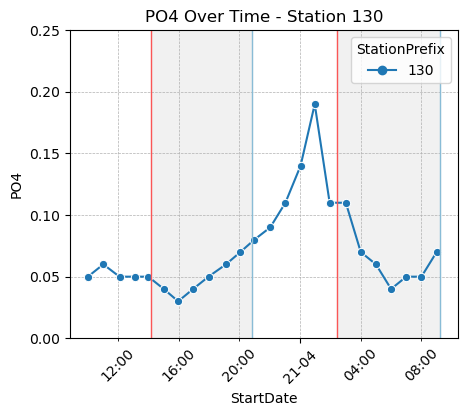

In [52]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'PO4', (0, 0.25), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


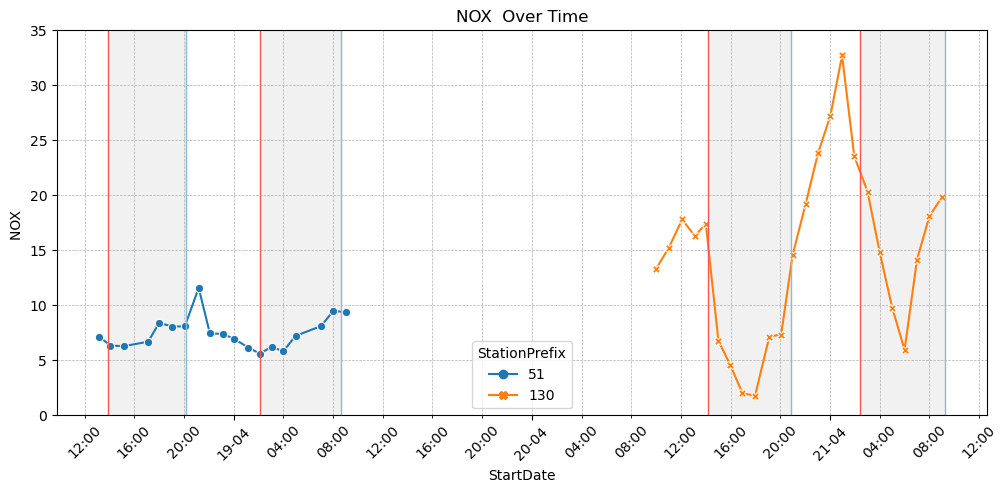

In [54]:
plot_environmental_variable(ctd_data, tides_df, 'NOX ', (0, 35), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


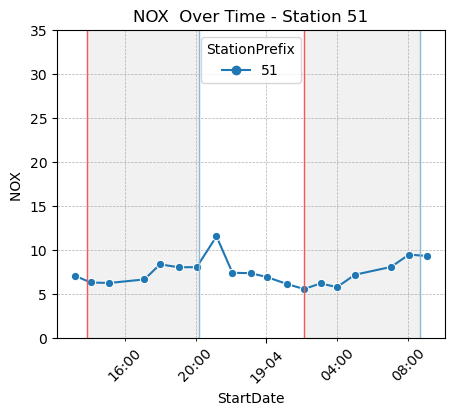

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


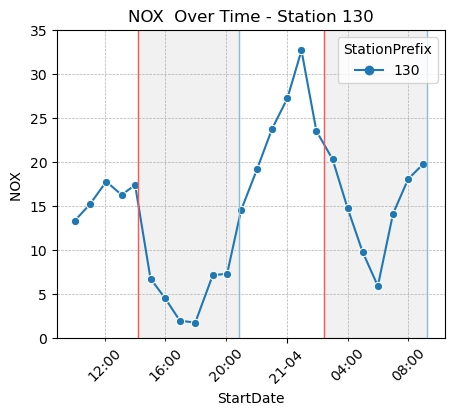

In [55]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NOX ', (0, 35), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


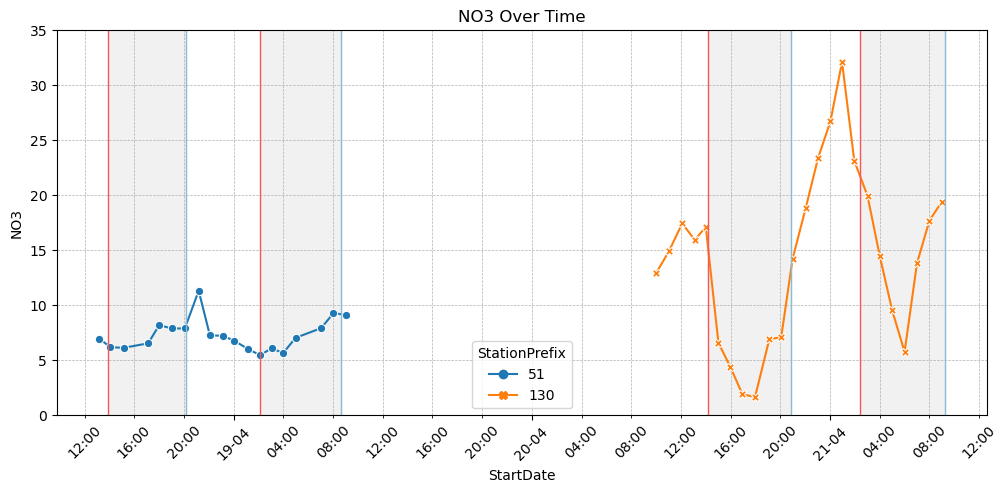

In [56]:
plot_environmental_variable(ctd_data, tides_df, 'NO3', (0, 35), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


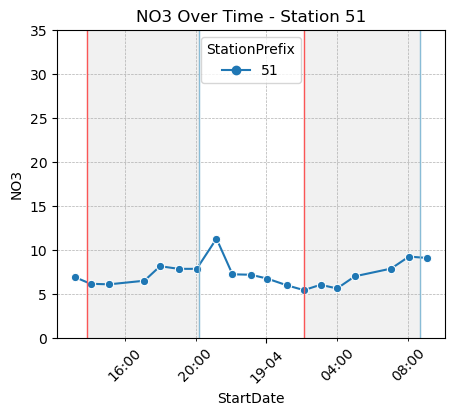

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


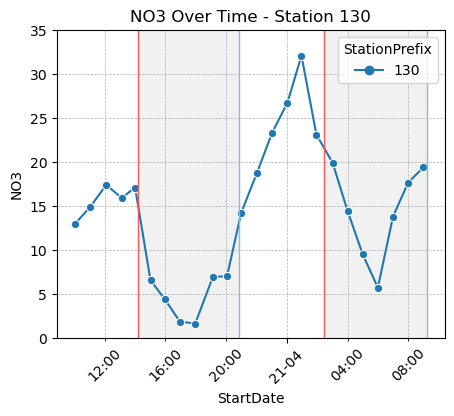

In [57]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NO3', (0, 35), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


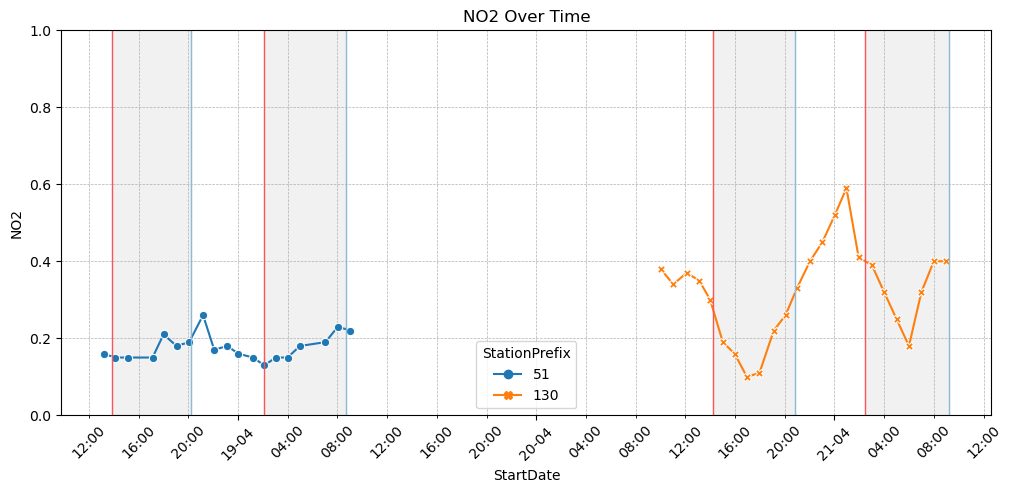

In [58]:
plot_environmental_variable(ctd_data, tides_df, 'NO2', (0, 1), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


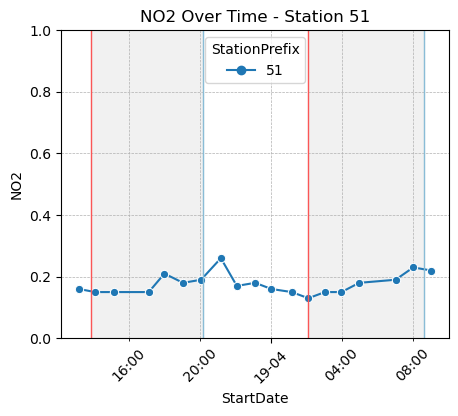

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


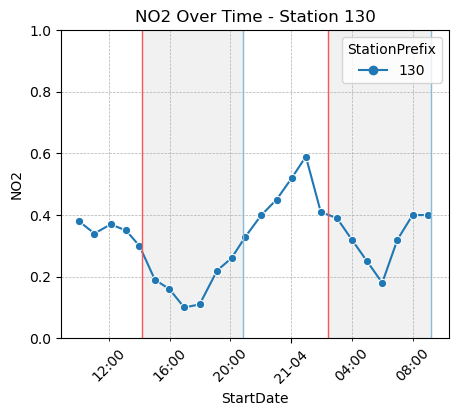

In [59]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NO2', (0, 1), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


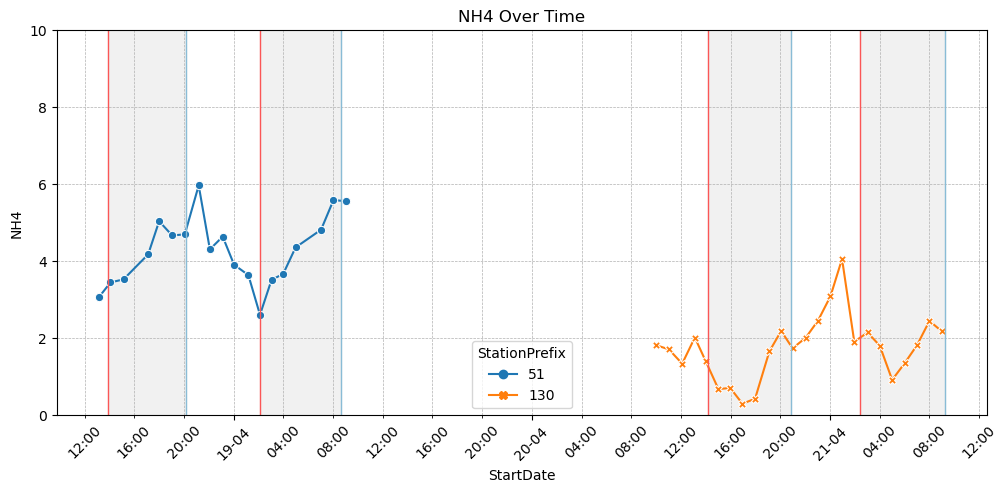

In [60]:
plot_environmental_variable(ctd_data, tides_df, 'NH4', (0, 10), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


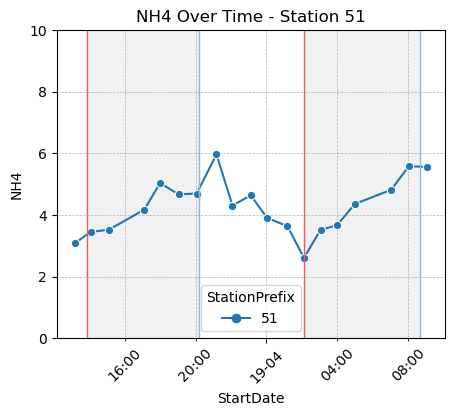

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


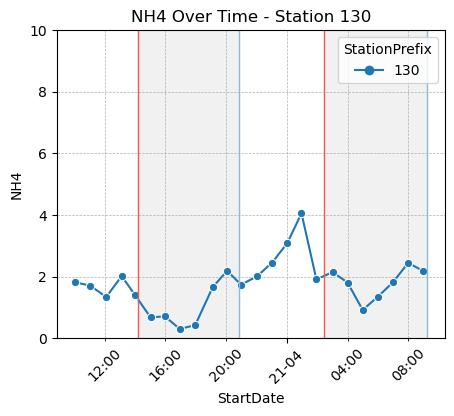

In [61]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NH4', (0, 10), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


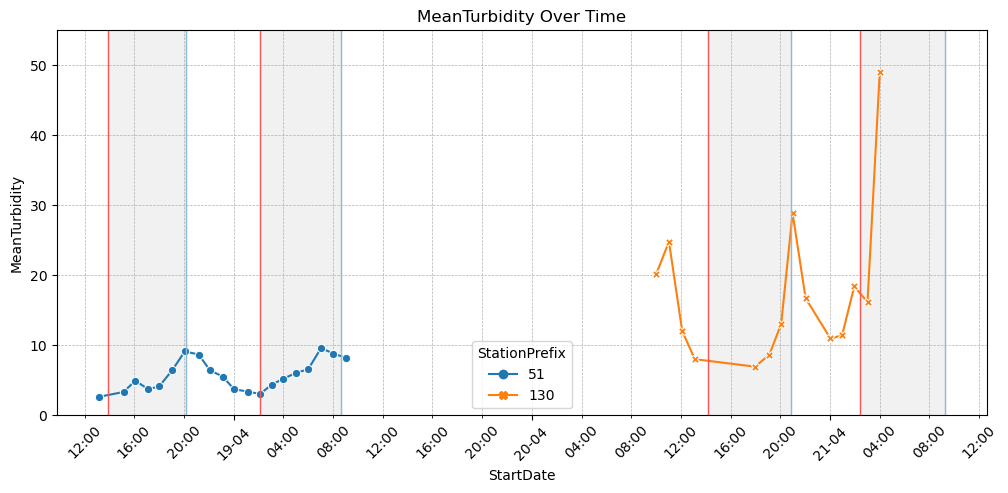

In [62]:
plot_environmental_variable(ctd_data, tides_df, 'MeanTurbidity', (0, 55), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


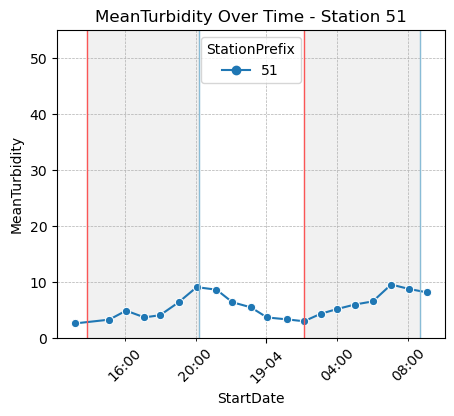

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


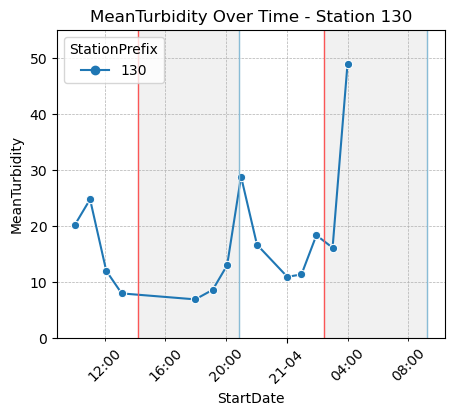

In [63]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTurbidity', (0, 55), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


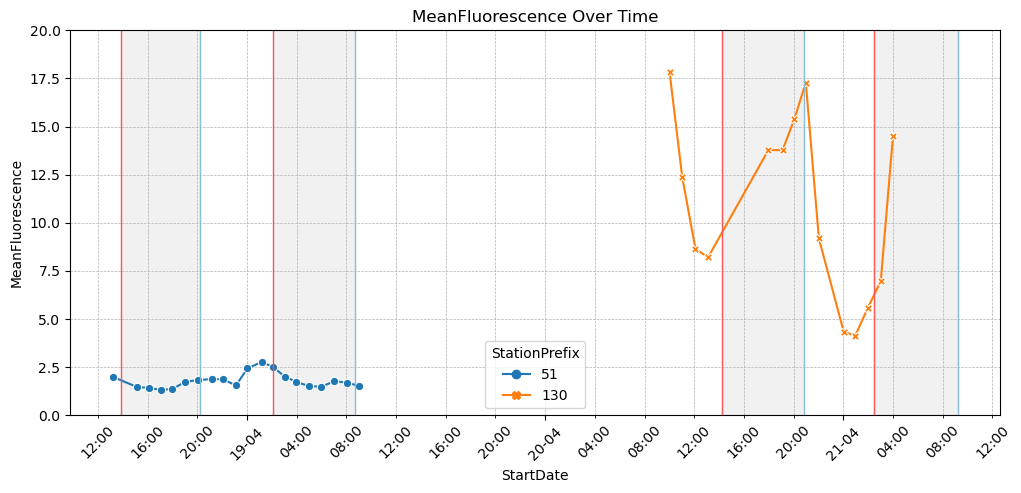

In [65]:
plot_environmental_variable(ctd_data, tides_df, 'MeanFluorescence', (0, 20), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


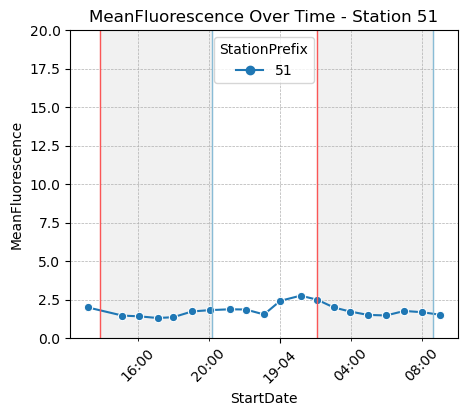

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


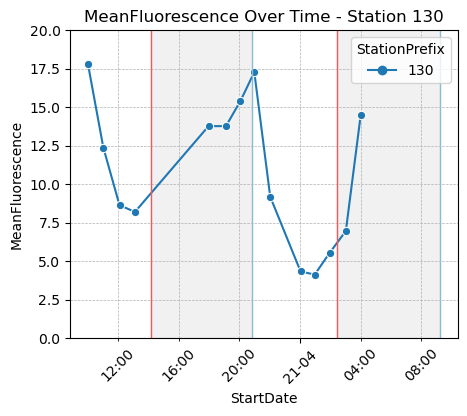

In [66]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanFluorescence', (0, 20), '../figures/environmental')

/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michiel/miniconda3/envs/spring_campaign_2023/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


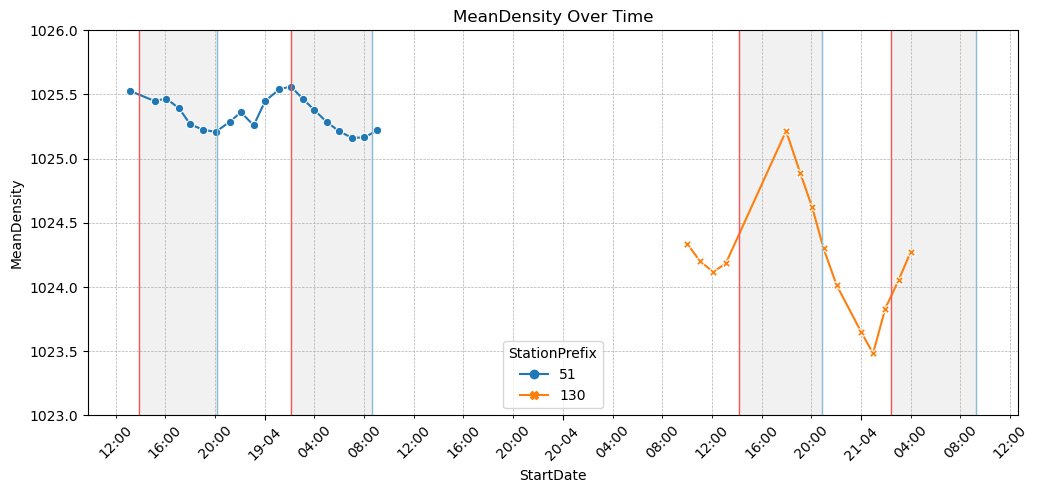

In [72]:
plot_environmental_variable(ctd_data, tides_df, 'MeanDensity', (1023, 1026), '../figures/environmental')

## WIP: Analysing the ship's location
Now we'll plot the sampling points and where the ship was at the time of sampling. We'll use the [Basemap](https://matplotlib.org/basemap/) package to plot the map.

In [ ]:
# Assuming ctd_data is your DataFrame
# Resample the data to have hourly data if it's not already
ctd_hourly = ctd_data.resample('H').first()

# Define a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Set up the Basemap
# This example sets up a world map in cylindrical projection. You can adjust the parameters as needed.
m = Basemap(projection='cyl', llcrnrlon=min(ctd_hourly['StartLong']) - 2, llcrnrlat=min(ctd_hourly['StartLat']) - 2,
            urcrnrlon=max(ctd_hourly['StartLong']) + 2, urcrnrlat=max(ctd_hourly['StartLat']) + 2, resolution='h', ax=ax)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')
m.drawparallels(np.arange(-90., 91., 1.), labels=[True, False, False, True], linewidth=0.5)
m.drawmeridians(np.arange(-180., 181., 1.), labels=[True, False, False, True], linewidth=0.5)
m.drawmapboundary(fill_color='aqua')

# Convert ship coordinates from lat/lon to map projection coordinates
x, y = m(ctd_hourly['StartLong'].values, ctd_hourly['StartLat'].values)
m.scatter(x, y, s=50, c='red', marker='o', edgecolors='k', label='Ship Position')

# Adding title and legend
plt.title("Ship's Hourly Positions")
plt.legend(loc='lower left')

# Save the figure as SVG
plt.savefig('ship_positions.svg', format='svg')
plt.show()

## Create environmental dataset for analysis
Here we'll combine the LW data, and buoy data, with sampling metadata in order to generate an easy dataset to work with in subsequent analyses. We'll pull in additional data using [bpnsdata](https://github.com/lifewatch/bpnsdata) if available.

In [38]:
# Clone the github package to the local machine and add it to the path
import sys
import os
sys.path.append('../../bpnsdata')
import bpnsdata
import geopandas as gpd
from suntime import Sun

In [39]:
os.environ['username_banken'] = 'michiel.perneel@vliz.be'
os.environ['password_banken'] = 'zYjjoj-kumtav-4himqe'

In [40]:
# Add date column to the ctd_data
ctd_data['Date'] = ctd_data.index

# Run the sea_manager over every row in the dataframe for the ERDDAP data
env_vars = ['shipping', 'time', 'wrakken_bank', 'habitat_suitability',
            'seabed_habitat', 'sea_surface']

sea_manager = bpnsdata.SeaDataManager(env_vars=env_vars)

results = []  # List to hold the result from each row

for index, row in ctd_data.iterrows():
    try:
        # Convert the single row DataFrame to a GeoDataFrame
        single_row_gdf = gpd.GeoDataFrame([row], geometry=gpd.points_from_xy([row['StartLong']], [row['StartLat']]), crs='EPSG:4269')
        
        # Calculate day length
        sun = Sun(row['StartLat'], row['StartLong'])
        sunrise = sun.get_sunrise_time(row['Date'])
        sunset = sun.get_sunset_time(row['Date'])
        day_length = sunset - sunrise  # This will give you a timedelta object
        
        # Process the row
        result = sea_manager(single_row_gdf, datetime_column='Date')
        
        # Add day length
        result['day_length'] = day_length.total_seconds() / 3600  # Day length in hours
        
        # Append the result
        results.append(result)
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# Concatenate all results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

In [41]:
results_df.columns

Index(['MeanConductivity', 'MeanDensity', 'MeanFluorescence', 'MeanPar',
       'MeanPressure', 'MeanSalinity', 'MeanSoundVelocity', 'MeanTemperature',
       'MeanTurbidity', 'NH4', 'NO2', 'NO3', 'NOX ', 'PO4', 'Si ',
       'TEP concentration avg', 'StationPrefix', 'StationSuffix', 'StartLat',
       'StartLong', 'Temperature', 'Salinity', 'Conductivity', 'Depth',
       'Oxygen', 'OxygenRaw', 'Station', 'Month', 'Year', 'Day', 'Hour',
       'Minute', 'Date', 'geometry', 'route_density', 'moon_phase',
       'day_moment', 'shipwreck_distance', 'shipwreck_lat', 'shipwreck_lon',
       'benthic_habitat', 'substrate', 'seabed_habitat',
       'surface_baroclinic_eastward_sea_water_velocity',
       'surface_baroclinic_northward_sea_water_velocity',
       'sea_surface_height_above_sea_level', 'sea_surface_salinity',
       'sea_surface_temperature', 'surface_baroclinic_sea_water_velocity',
       'day_length'],
      dtype='object')

In [42]:
# Filter out the columns that are not needed
columns_of_interest = ['MeanFluorescence', 'NH4', 'NO2', 'NO3', 'NOX ', 'PO4', 'Si ',
       'TEP concentration avg', 'StationPrefix', 'StationSuffix', 'StartLat', 'StartLong',
       'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen', 'Station', 'Date',
       'day_moment', 'sea_surface_height_above_sea_level', 'surface_baroclinic_sea_water_velocity', 'day_length']

results_df = results_df[columns_of_interest]

# Rename the columns
results_df.columns = ['Fluorescence', 'NH4', 'NO2', 'NO3', 'NOX', 'PO4', 'Si',
       'TEP_concentration_avg', 'StationPrefix', 'StationSuffix', 'Latitude', 'Longitude',
       'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen', 'Station', 'Date',
       'day_moment', 'sea_surface_height_above_sea_level', 'surface_baroclinic_sea_water_velocity', 'day_length']

# Put station column first
results_df = results_df[['Station', 'StationPrefix', 'StationSuffix', 'Latitude', 'Longitude', 'Date', 'day_moment', 'day_length',
                         'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen', 'Fluorescence', 'NH4', 'NO2', 'NO3', 'NOX', 'PO4', 'Si',
                         'TEP_concentration_avg', 'sea_surface_height_above_sea_level', 'surface_baroclinic_sea_water_velocity']]

# Save the results to a CSV file
results_df.to_csv('../data/samples_env.csv')

## Correlation analysis

In [ ]:
# Function to compute correlation and p-values
def calculate_pvals(data):
    pvals = np.ones((data.shape[1], data.shape[1]))
    corrs = data.corr()
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            if i != j:
                _, pvals[i, j] = pearsonr(data.iloc[:, i], data.iloc[:, j])
            else:
                pvals[i, j] = np.nan  # Ignore diagonal
    return corrs, pvals

# Calculate correlation matrix and p-values matrix
correlation_matrix, p_values_matrix = calculate_pvals(data_clean[environmental_columns])

# Flatten the p-values and apply Bonferroni correction
corrected_p_values = multipletests(p_values_matrix.flatten(), method='bonferroni')[1]
p_values_matrix_corrected = corrected_p_values.reshape(p_values_matrix.shape)

# Mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a custom annotator to include p-values with Bonferroni correction
def annotator(data, pvals, threshold=0.05):
    labels = np.empty_like(data, dtype=object)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data[i, j]
            pval = pvals[i, j]
            if pval < threshold:
                labels[i, j] = f"{value:.2f}*"
            else:
                labels[i, j] = f"{value:.2f}"
    return labels

# Annotations combining correlation values and significance
labels = annotator(correlation_matrix.values, p_values_matrix_corrected)

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.set(font_scale=0.8)
heatmap = sns.heatmap(correlation_matrix,
                      annot=labels,
                      fmt="",
                      cmap='coolwarm',
                      cbar=True,
                      linewidths=.5,
                      mask=mask)
plt.title('Heatmap of Pearson Correlations\nBetween Environmental Variables')
plt.gca().patch.set_facecolor('white')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# Save the heatmap
plt.savefig('../../figures/environmental/heatmap_correlations_env.svg')
plt.savefig('../../figures/environmental/heatmap_correlations_env.png')
plt.show()
